In [1]:
# Author: Amit Parag
# Date : 11 May, 2022


import numpy as np
import torch
from tqdm import tqdm
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from torch.nn.functional import mse_loss as mse
import pandas

from datagen import solve_ocps
from nn import ActorResidualCritic
from optimal_control.ddp import init_ddp,extract_ddp_data
from optimal_control.samples import uniform_samples
from optimal_control.robot import load_robot
from optimal_control.plot_results import plot_warmstart
from optimal_control.plot_results import plot_warmstarts
from optimal_control.plot_results import plot_warmstart_ee

from optimal_control.path import exp_path



sns.set(font_scale=1.5)
plt.rc('text', usetex=True)

sns.set_context("paper",rc={"lines.linewidth": 2.5})
sns.axes_style("white")
sns.color_palette("husl", 3)
sns.set(font_scale = 1.5)
sns.set_style("whitegrid", {'axes.grid' :False,'grid.linestyle': '--'})

##################################################33









robot, config = load_robot()

torch.manual_seed(0)
np.random.seed(0)

exp_number  =   1
eps_number  =   21
save_path   =   exp_path(exp_number=exp_number,make_path=False,get_path=True)
model       =   torch.load(save_path+f'/eps_{eps_number}.pth')
    




Successfully Loaded Robot


/home/amit/workspace/refining_disjoint/src/optimal_control/path.py:18: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f)


In [12]:

def check_iters(model,nb_samples=160):


    x0s     = uniform_samples(nb_samples=nb_samples,robot=robot,config=config)
    #print("Base\t\tResidual\t\tDisjoint")

    ddp_iter    =   []
    dvp_iter    =   []


    for x0 in tqdm(x0s):

        ### BASE
        ddp     =   init_ddp(robot=robot,config=config,x0=x0,N_h=100)
        ddp.solve()
        ddp_iter.append( ddp.iter )
        


        ### Disjoint
        xs, us  =   model.warmstart(x0)
        ddp3    =   init_ddp(robot=robot,config=config,x0=x0,actorResidualCritic=model,N_h=100)
        xs      =   xs[:101]
        us      =   us[:100]
        ddp3.solve(init_xs=xs,init_us=us,maxiter=1000,isFeasible=False)
        dvp_iter.append( ddp3.iter )
        

    return ddp_iter, dvp_iter

In [13]:
d1, d2 = check_iters(model,600)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:43<00:00, 13.80it/s]


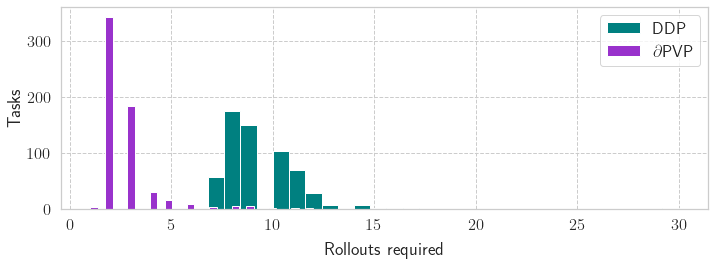

In [51]:
fig, ax = plt.subplots(figsize=(11.6,3.71))


ax.hist(d1, bins=30,color='teal',label='DDP')
ax.hist(d2, bins=30,label=r"$\partial$PVP",color='darkorchid')
ax.set_ylabel("Tasks")
ax.set_xlabel("Rollouts required",labelpad=10)
#ax.set_yticks(np.arange(0,len(d1)+1))
#MEAN
#ax.axvline(sum(d1)/len(d1), color='k', linestyle='dashed', linewidth=5)
#ax.axvline(sum(d2)/len(d2), color='k', linestyle='dashed', linewidth=5)
ax.grid(True)

plt.legend()
plt.savefig("../results/exp_1/iters.png")

600